In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
def calc_snr(signal):
    noise = signal-np.mean(signal)
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = np.mean(np.abs(noise)**2)
    snr = 10*np.log10(signal_power/noise_power)
    return snr


Length of nuc3_cons: 259200, Half of nuc3_cons: 129600.0


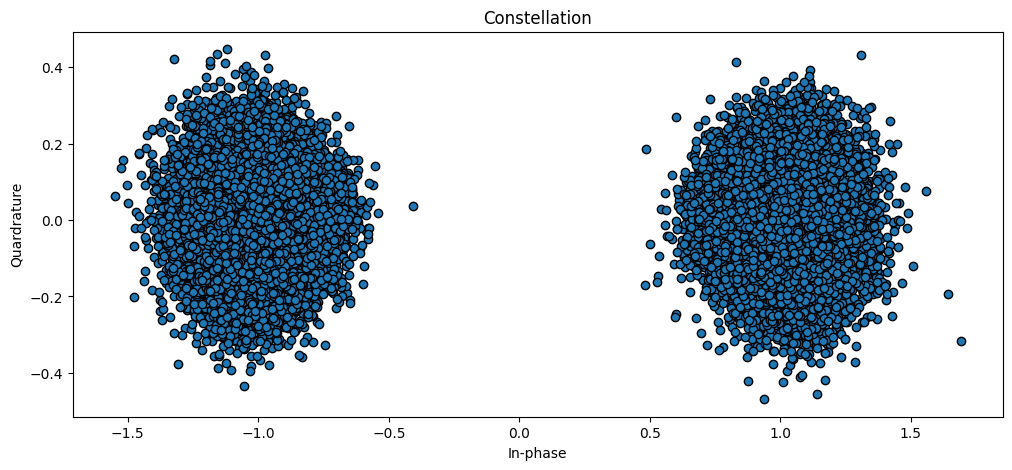

In [3]:
nuc3_cons = np.fromfile('csibins/mins/nuc3-2min/csibins/wifi_constellation.bin',dtype=np.complex64)

plt.figure(figsize=(12,5))
plt.title('Constellation')
plt.ylabel('Quardrature')
plt.xlabel('In-phase')
plt.scatter(nuc3_cons.real[:len(nuc3_cons)//2], nuc3_cons.imag[:len(nuc3_cons)//2],edgecolors='black')
print(f'Length of nuc3_cons: {len(nuc3_cons)}, Half of nuc3_cons: {len(nuc3_cons)/2}')

Length of nuc3_mag: 402.0


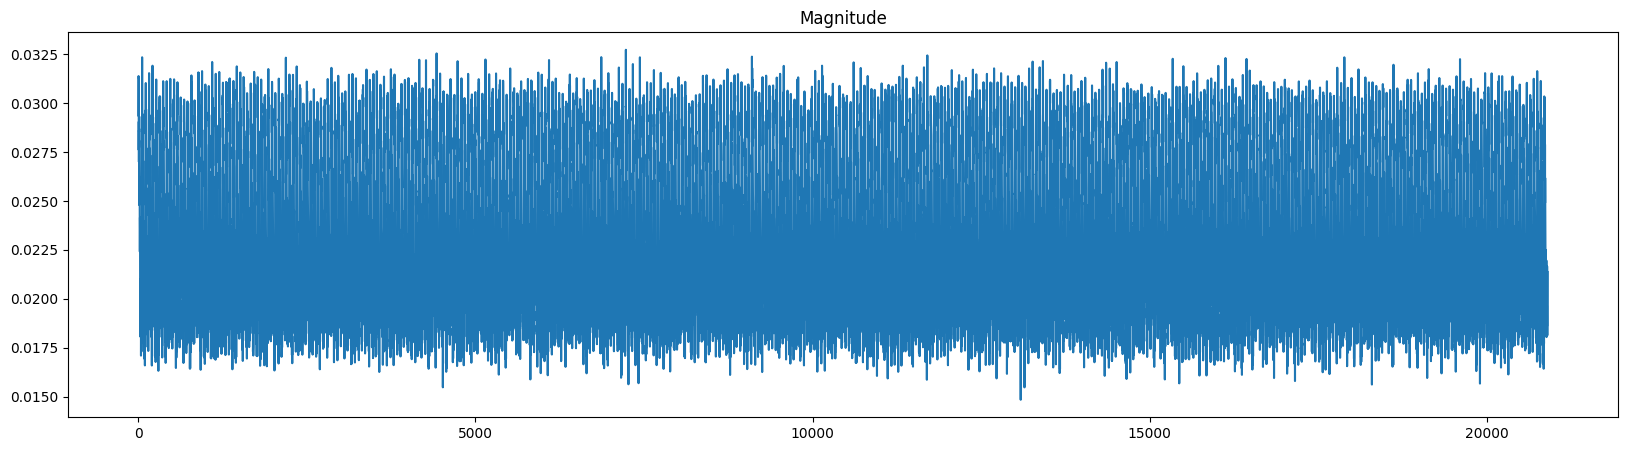

In [4]:
nuc3_mag = np.fromfile('csibins/mins/nuc3-2min/csibins/wifi_mag.bin',dtype=np.float32)
nuc3_phase = np.fromfile('csibins/mins/nuc3-2min/csibins/wifi_phase.bin',dtype=np.float32)
nuc3_amplitude = np.fromfile('csibins/mins/nuc3-2min/csibins/wifi_Amplitude.bin',dtype=np.float32)

plt.figure(figsize=(20,5))
plt.title('Magnitude')
plt.plot(np.arange(len(nuc3_mag)), nuc3_mag)
print(f'Length of nuc3_mag: {len(nuc3_mag)/52}')

## Analysis of CSI

### This CSI data was captured over POWDER while simulating the IEEE 802.11 standard

#### Below are side by side comparisons of various CSI metrics

Length of nuc4_cons: 274560, Half of nuc4_cons: 137280.0


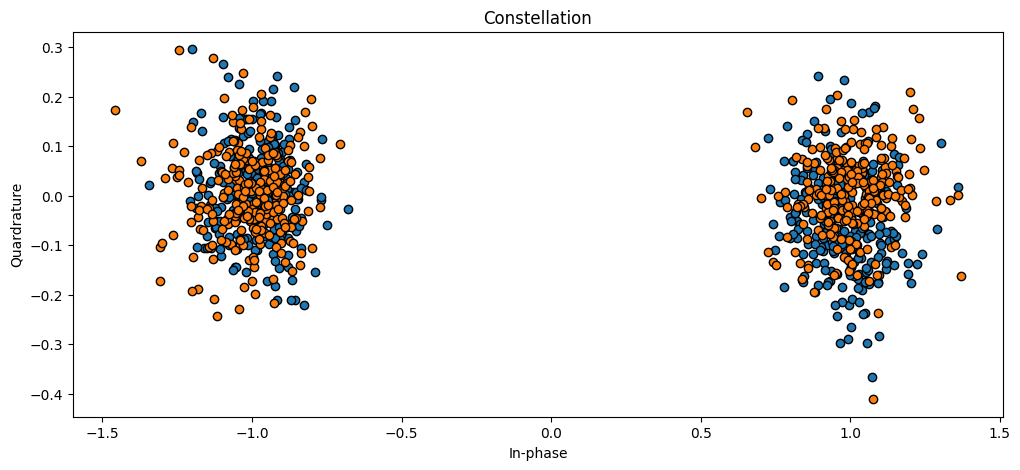

In [5]:
nuc4_cons = np.fromfile('csibins/mins/nuc4-2min/csibins/wifi_constellation.bin',dtype=np.complex64)
nuc4_mag = np.fromfile('csibins/mins/nuc4-2min/csibins/wifi_mag.bin',dtype=np.float32)
nuc4_phase = np.fromfile('csibins/mins/nuc4-2min/csibins/wifi_phase.bin',dtype=np.float32)
nuc4_amplitude = np.fromfile('csibins/mins/nuc4-2min/csibins/wifi_Amplitude.bin',dtype=np.float32)

plt.figure(figsize=(12,5))
plt.title('Constellation')
plt.ylabel('Quardrature')
plt.xlabel('In-phase')
plt.scatter(nuc4_cons.real[:520], nuc4_cons.imag[:520],edgecolors='black')
plt.scatter(nuc3_cons.real[:520], nuc3_cons.imag[:520],edgecolors='black')
print(f'Length of nuc4_cons: {len(nuc4_cons)}, Half of nuc4_cons: {len(nuc4_cons)/2}')

#### Magnitude and Phase

Below is a plot of approximately 10 Packets Transmitted.

As seen from magnitude plots for the two similar hardware devices we can see sufficient difference in them to be classified as different with both devices showing a repeating pattern at different magnitudes.

Length of nuc3_mag: 402.0


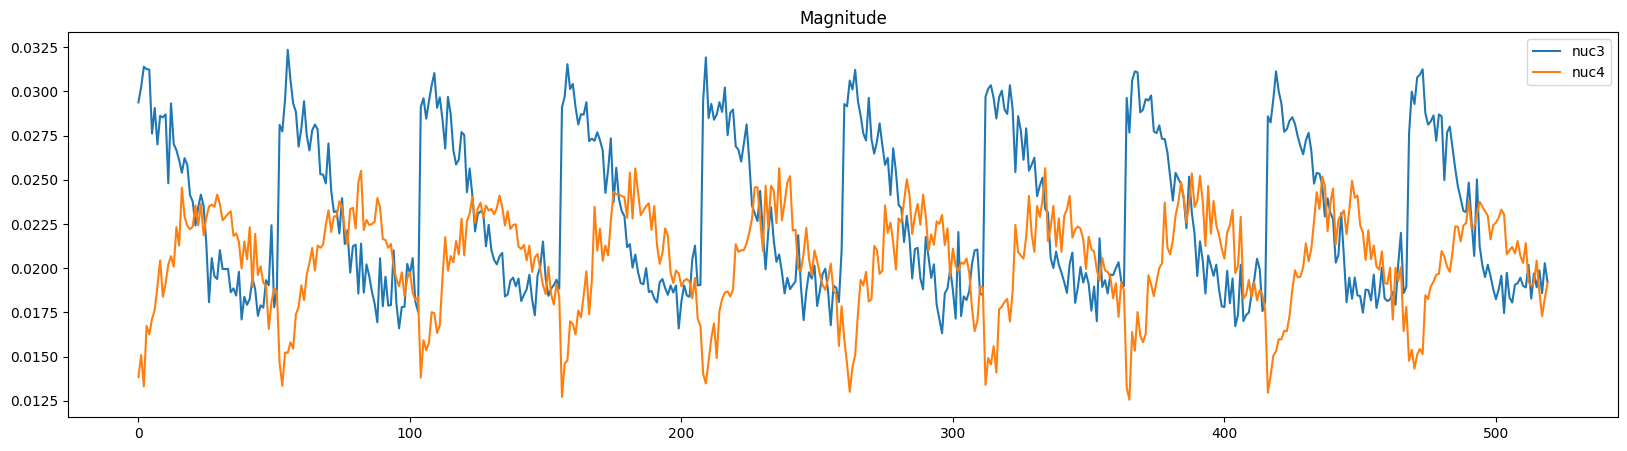

In [6]:
plt.figure(figsize=(20,5))
plt.title('Magnitude')
plt.plot(np.arange(len(nuc3_mag))[:520], nuc3_mag[:520],label='nuc3')
plt.plot(np.arange(len(nuc4_mag))[:520], nuc4_mag[:520],label='nuc4')
plt.legend()
print(f'Length of nuc3_mag: {len(nuc3_mag)/52}')

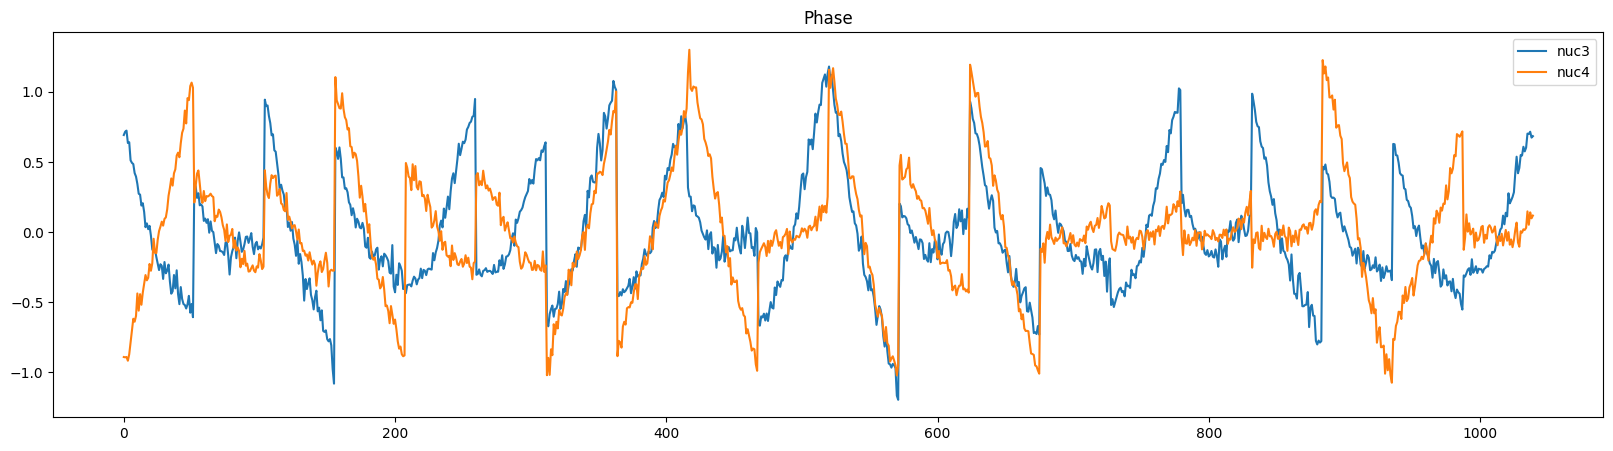

In [7]:
plt.figure(figsize=(20,5))
plt.title('Phase')
plt.plot(np.arange(len(nuc3_phase))[:1040],nuc3_phase[:1040], label='nuc3')
plt.plot(np.arange(len(nuc4_phase))[:1040],nuc4_phase[:1040], label='nuc4')
plt.legend()


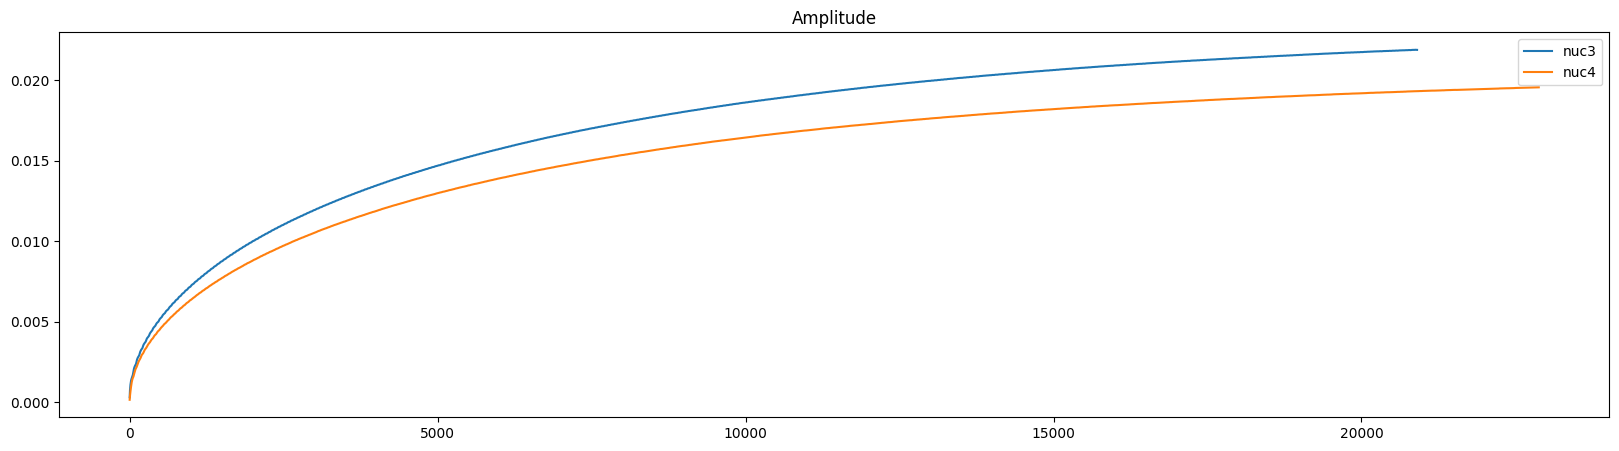

In [8]:
plt.figure(figsize=(20,5))
plt.title('Amplitude')
plt.plot(np.arange(len(nuc3_amplitude)), nuc3_amplitude,label='nuc3')
plt.plot(np.arange(len(nuc4_amplitude)), nuc4_amplitude,label='nuc4')
plt.legend()


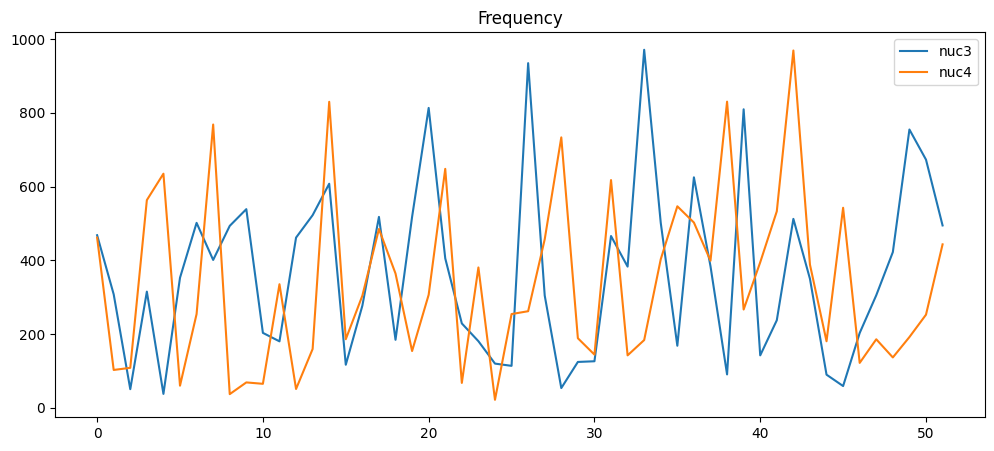

In [9]:
nuc3_freq_data = np.fft.fft(nuc3_cons)
samp_rate = 10e6
num_samples = len(nuc3_cons)
nuc3_freq_bins = np.fft.fftfreq(num_samples, d = 1/num_samples)

nuc4_freq_data = np.fft.fft(nuc4_cons)
samp_rate = 10e6
num_samples = len(nuc4_cons)
nuc4_freq_bins = np.fft.fftfreq(num_samples, d = 1/num_samples)


# plt.title('Frequency')
plt.figure(figsize=(12,5))
# plt.figure(figsize=(12,5))
plt.title('Frequency')
plt.plot(nuc3_freq_bins[:52],np.abs(nuc3_freq_data)[:52],label='nuc3')
plt.plot(nuc4_freq_bins[:52],np.abs(nuc4_freq_data)[:52],label='nuc4')
plt.legend()

#### Proposed Model

from above analysis i think mag and phase should be sufficient to classify on devices and following Model Structure based on use of Conv1D ( [Exposing the Fingerprint: Dissecting the Impact of the Wireless Channel on Radio Fingerprinting](https://ieeexplore.ieee.org/document/9155259) ) a multiple input model taking in the Magnitude and Phase Values in windows of 52 (Each Packet cosisted of 52 i/q elements on Capturing) should be sufficient.


In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

# Define input layers
input1 = Input(shape=(52,1), name='magnitude')
input2 = Input(shape=(52,1), name='phase')

# Conv1D processing for input1
x1 = Conv1D(filters=32, kernel_size=3, activation='relu')(input1)
x1 = Flatten()(x1)

# Conv1D processing for input2
x2 = Conv1D(filters=32, kernel_size=3, activation='relu')(input2)
x2 = Flatten()(x2)

# Concatenate the processed inputs
concatenated = Concatenate()([x1, x2])

# Add dense layers for classification
x = Dense(64, activation='relu')(concatenated)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=[input1, input2], outputs=output, name='rf_fingerprinting')

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "rf_fingerprinting"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 magnitude (InputLayer)      [(None, 52, 1)]              0         []                            
                                                                                                  
 phase (InputLayer)          [(None, 52, 1)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 50, 32)               128       ['magnitude[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 50, 32)               128       ['phase[0][0]']               
                                                                                  

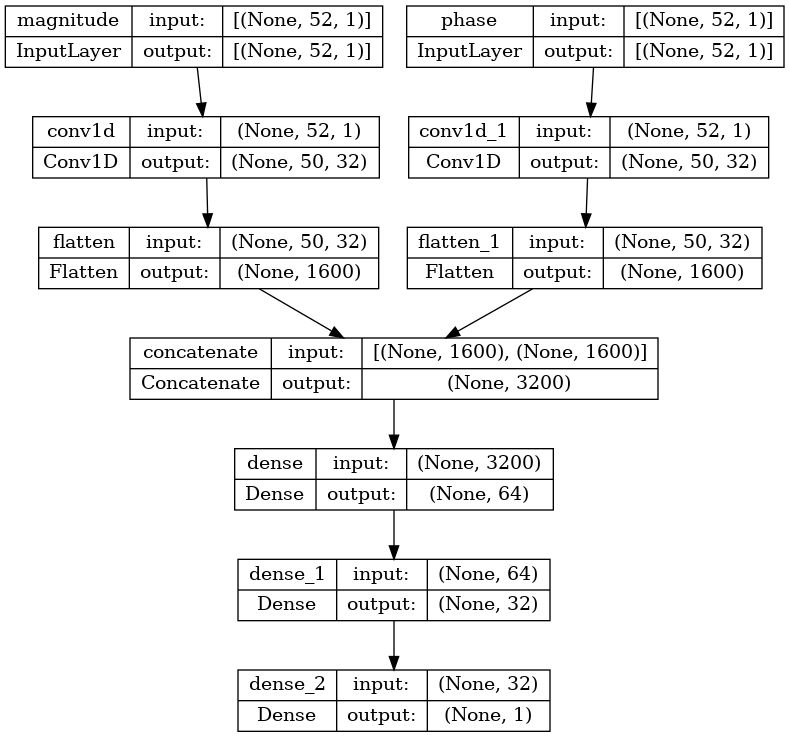

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)